In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as tt
import seaborn as sns
from scipy import stats

In [7]:
!curl https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.csv > data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 86845  100 86845    0     0   700k      0 --:--:-- --:--:-- --:--:--  700k


In [11]:
df = pd.read_csv('data.csv')
df['ds'] = pd.to_datetime(df['ds'])
df['y_scaled'] = (df['y'] - df['y'].min()) / (df['y'].max() - df['y'].min())
df['t'] = (df['ds'] - df['ds'].min()) / (df['ds'].max() - df['ds'].min())


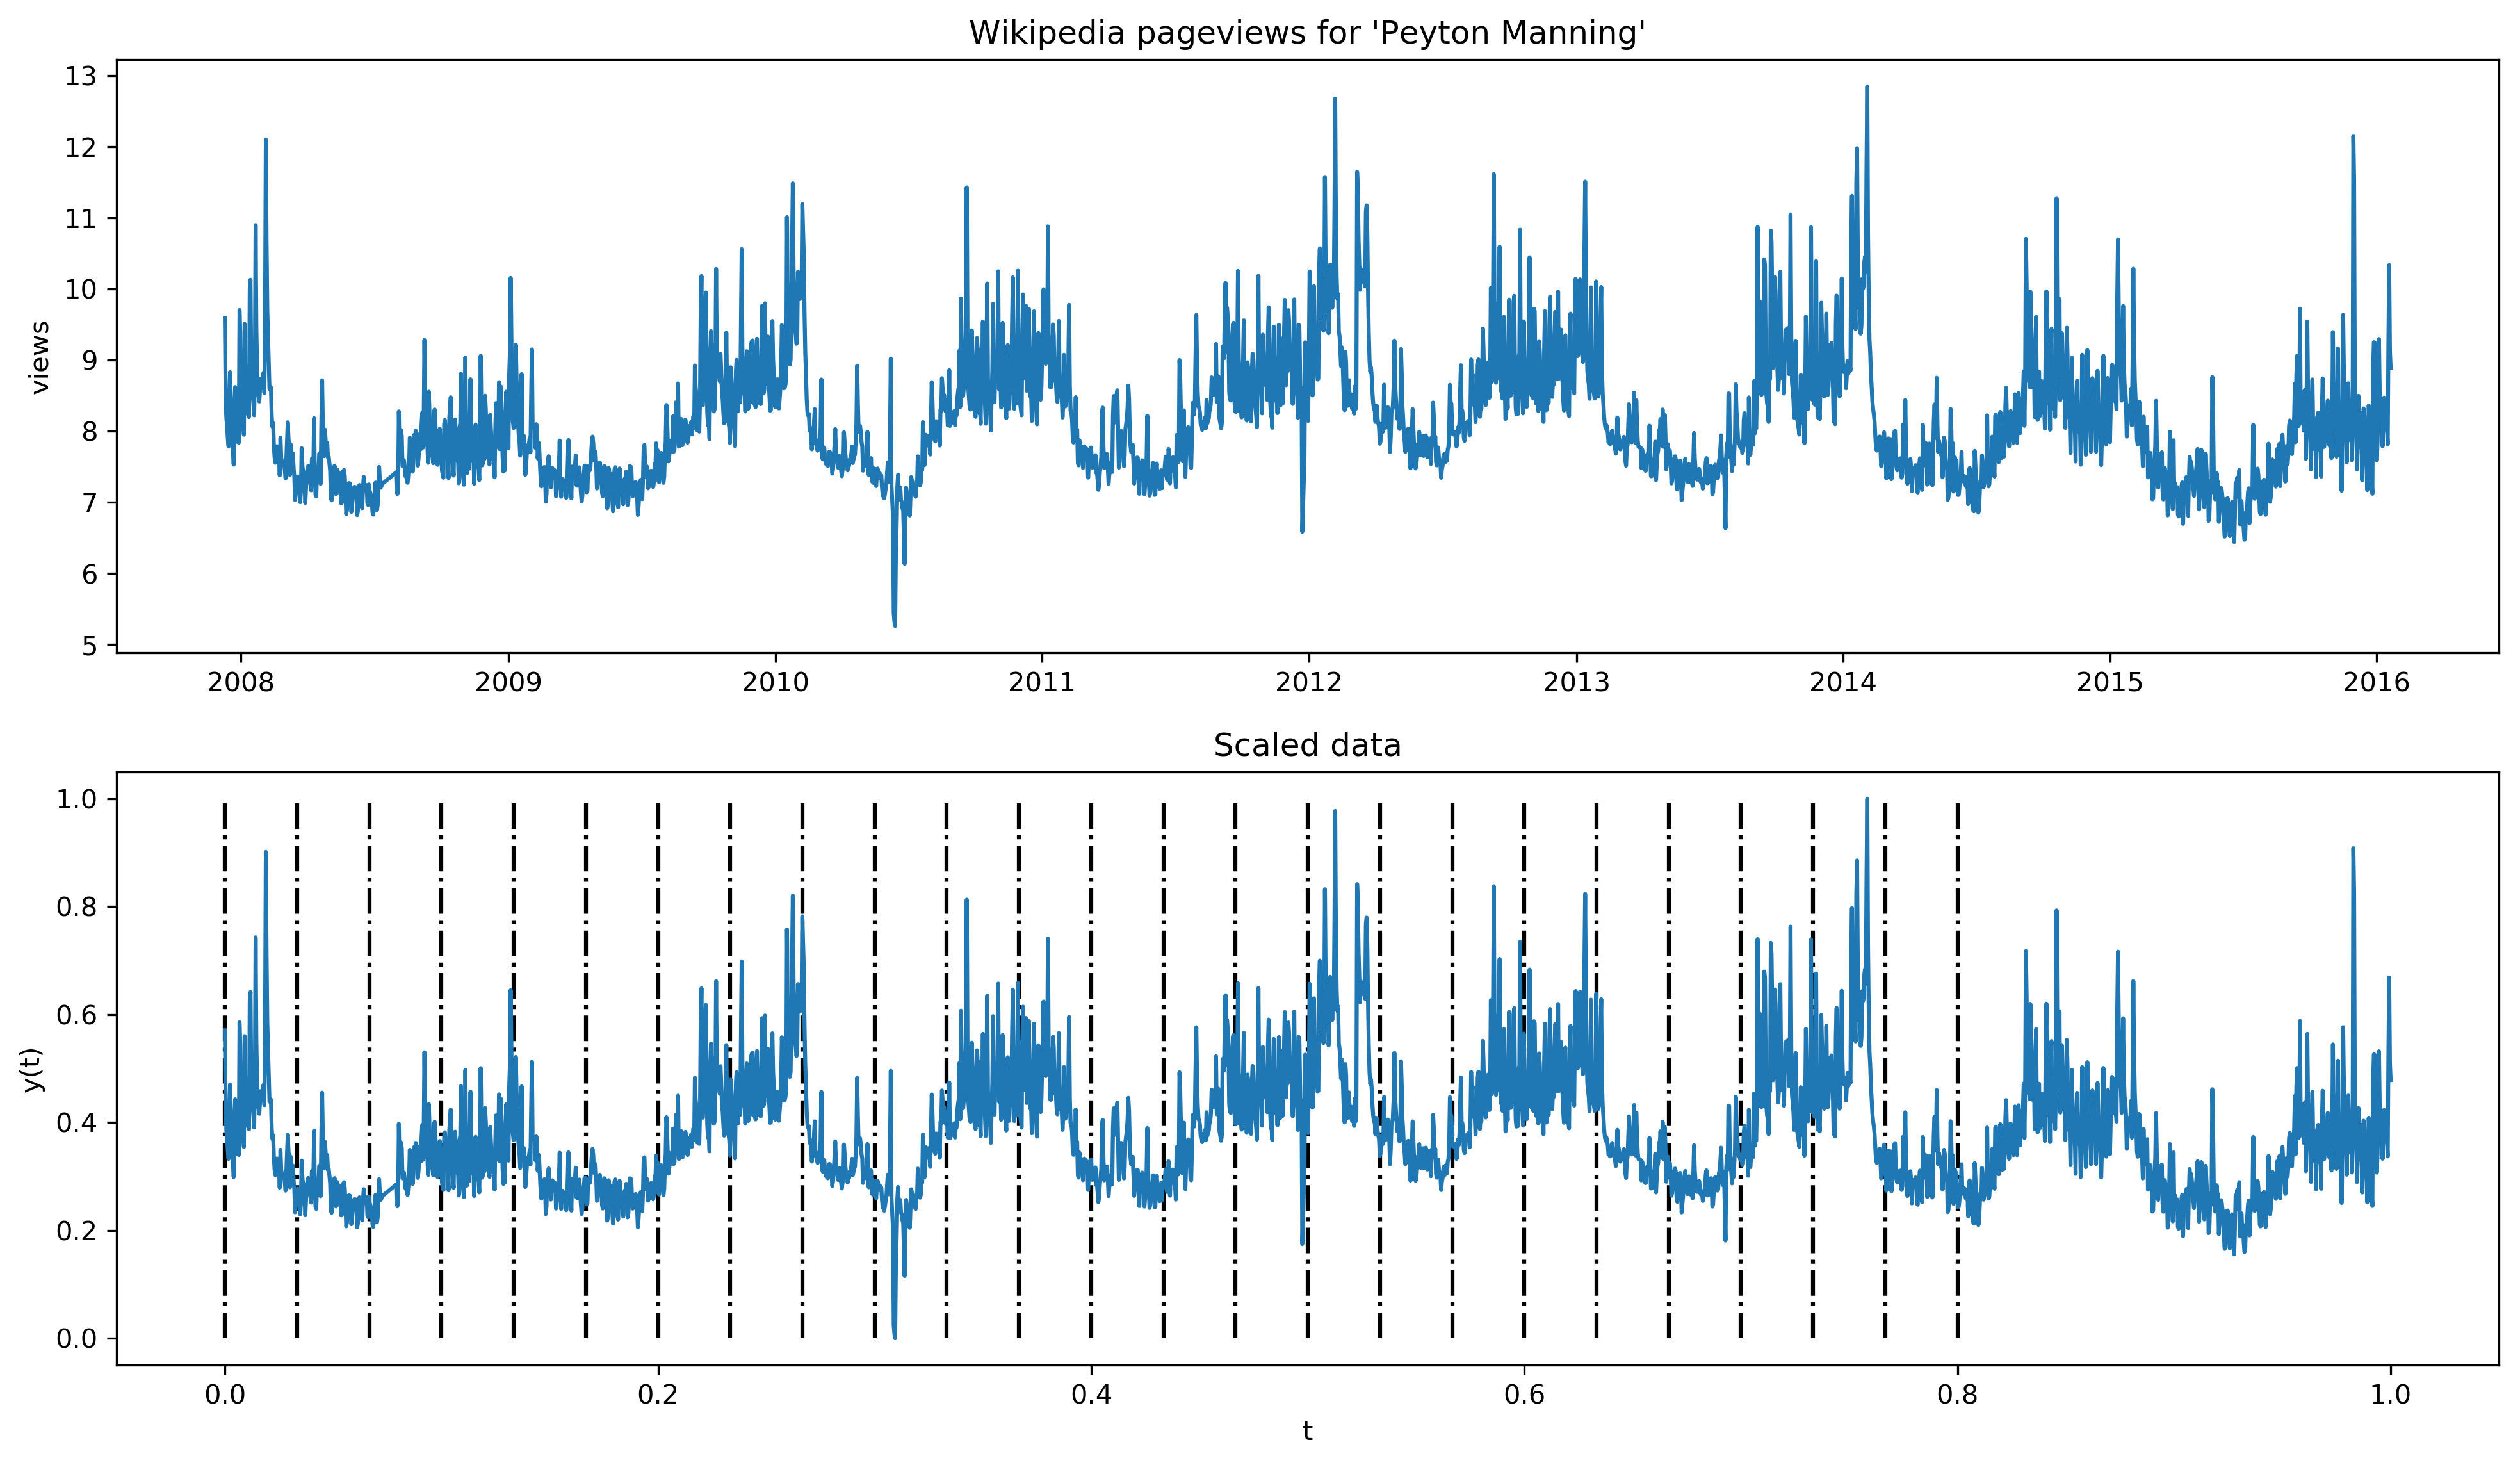

In [21]:
np.random.seed(25)

n_changepoints = 25
t = np.linspace(0, 1, 1000)

s = np.linspace(0, t[-1] * 0.8, n_changepoints)

# plt.figure(figsize=(16, 3))
# plt.xlabel('t')
# plt.yticks([])


fig = plt.figure(figsize=(16, 9), dpi=300)
fig.patch.set_facecolor('white')
plt.subplot(211)

plt.title("Wikipedia pageviews for 'Peyton Manning'")
plt.ylabel('views')
plt.plot(df['ds'], df['y'])

plt.subplot(212)
plt.title('Scaled data')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.plot(df['t'], df['y_scaled'])
plt.vlines(s, 0, df['t'].max(), linestyle='-.')

In [13]:
def det_dot(a, b):
    """
    The theano dot product and NUTS sampler don't work with large matrices?
    
    :param a: (np matrix)
    :param b: (theano vector)
    """
    return (a * b[None, :]).sum(axis=-1)

def trend_model(m, t, n_changepoints=25, changepoints_prior_scale=0.05, 
                growth_prior_scale=5, changepoint_range=0.8):
    """
    The piecewise linear trend with changepoint implementation in PyMC3.
    :param m: (pm.Model)
    :param t: (np.array) MinMax scaled time.
    :param n_changepoints: (int) The number of changepoints to model.
    :param changepoint_prior_scale: (flt/ None) The scale of the Laplace prior on the delta vector.
                                    If None, a hierarchical prior is set.
    :param growth_prior_scale: (flt) The standard deviation of the prior on the growth.
    :param changepoint_range: (flt) Proportion of history in which trend changepoints will be estimated. 
    :return g, A, s: (tt.vector, np.array, tt.vector)
    """
    s = np.linspace(0, changepoint_range * np.max(t), n_changepoints + 1)[1:]
    
    # * 1 casts the boolean to integers
    A = (t[:, None] > s) * 1

    with m:
        # initial growth
        k = pm.Normal('k', 0 , growth_prior_scale)
        
        if changepoints_prior_scale is None:
            changepoints_prior_scale = pm.Exponential('tau', 1.5)
        
        # rate of change
        delta = pm.Laplace('delta', 0, changepoints_prior_scale, shape=n_changepoints)
        # offset
        m = pm.Normal('m', 0, 5)
        gamma = -s * delta
        
        g = (k + det_dot(A, delta)) * t + (m + det_dot(A, gamma))
    return g, A, s



with pm.Model() as m:
    y, A, s = trend_model(m, df['t'])
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    pm.Normal('obs', 
                 mu=y,
                 sd=sigma,
                 observed=df['y_scaled'])
    aprox_1 = pm.find_MAP()
    

with pm.Model() as m:
    y, A, s = trend_model(m, df['t'], changepoints_prior_scale=0.5)
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    pm.Normal('obs', 
                 mu=y,
                 sd=sigma,
                 observed=df['y_scaled'])
    aprox_2 = pm.find_MAP()



logp = 2,462.8, ||grad|| = 144.39: 100%|██████████| 317/317 [00:00<00:00, 865.22it/s] 
logp = 2,888.9, ||grad|| = 15.047: 100%|██████████| 1093/1093 [00:01<00:00, 880.55it/s]


([], <a list of 0 Text yticklabel objects>)

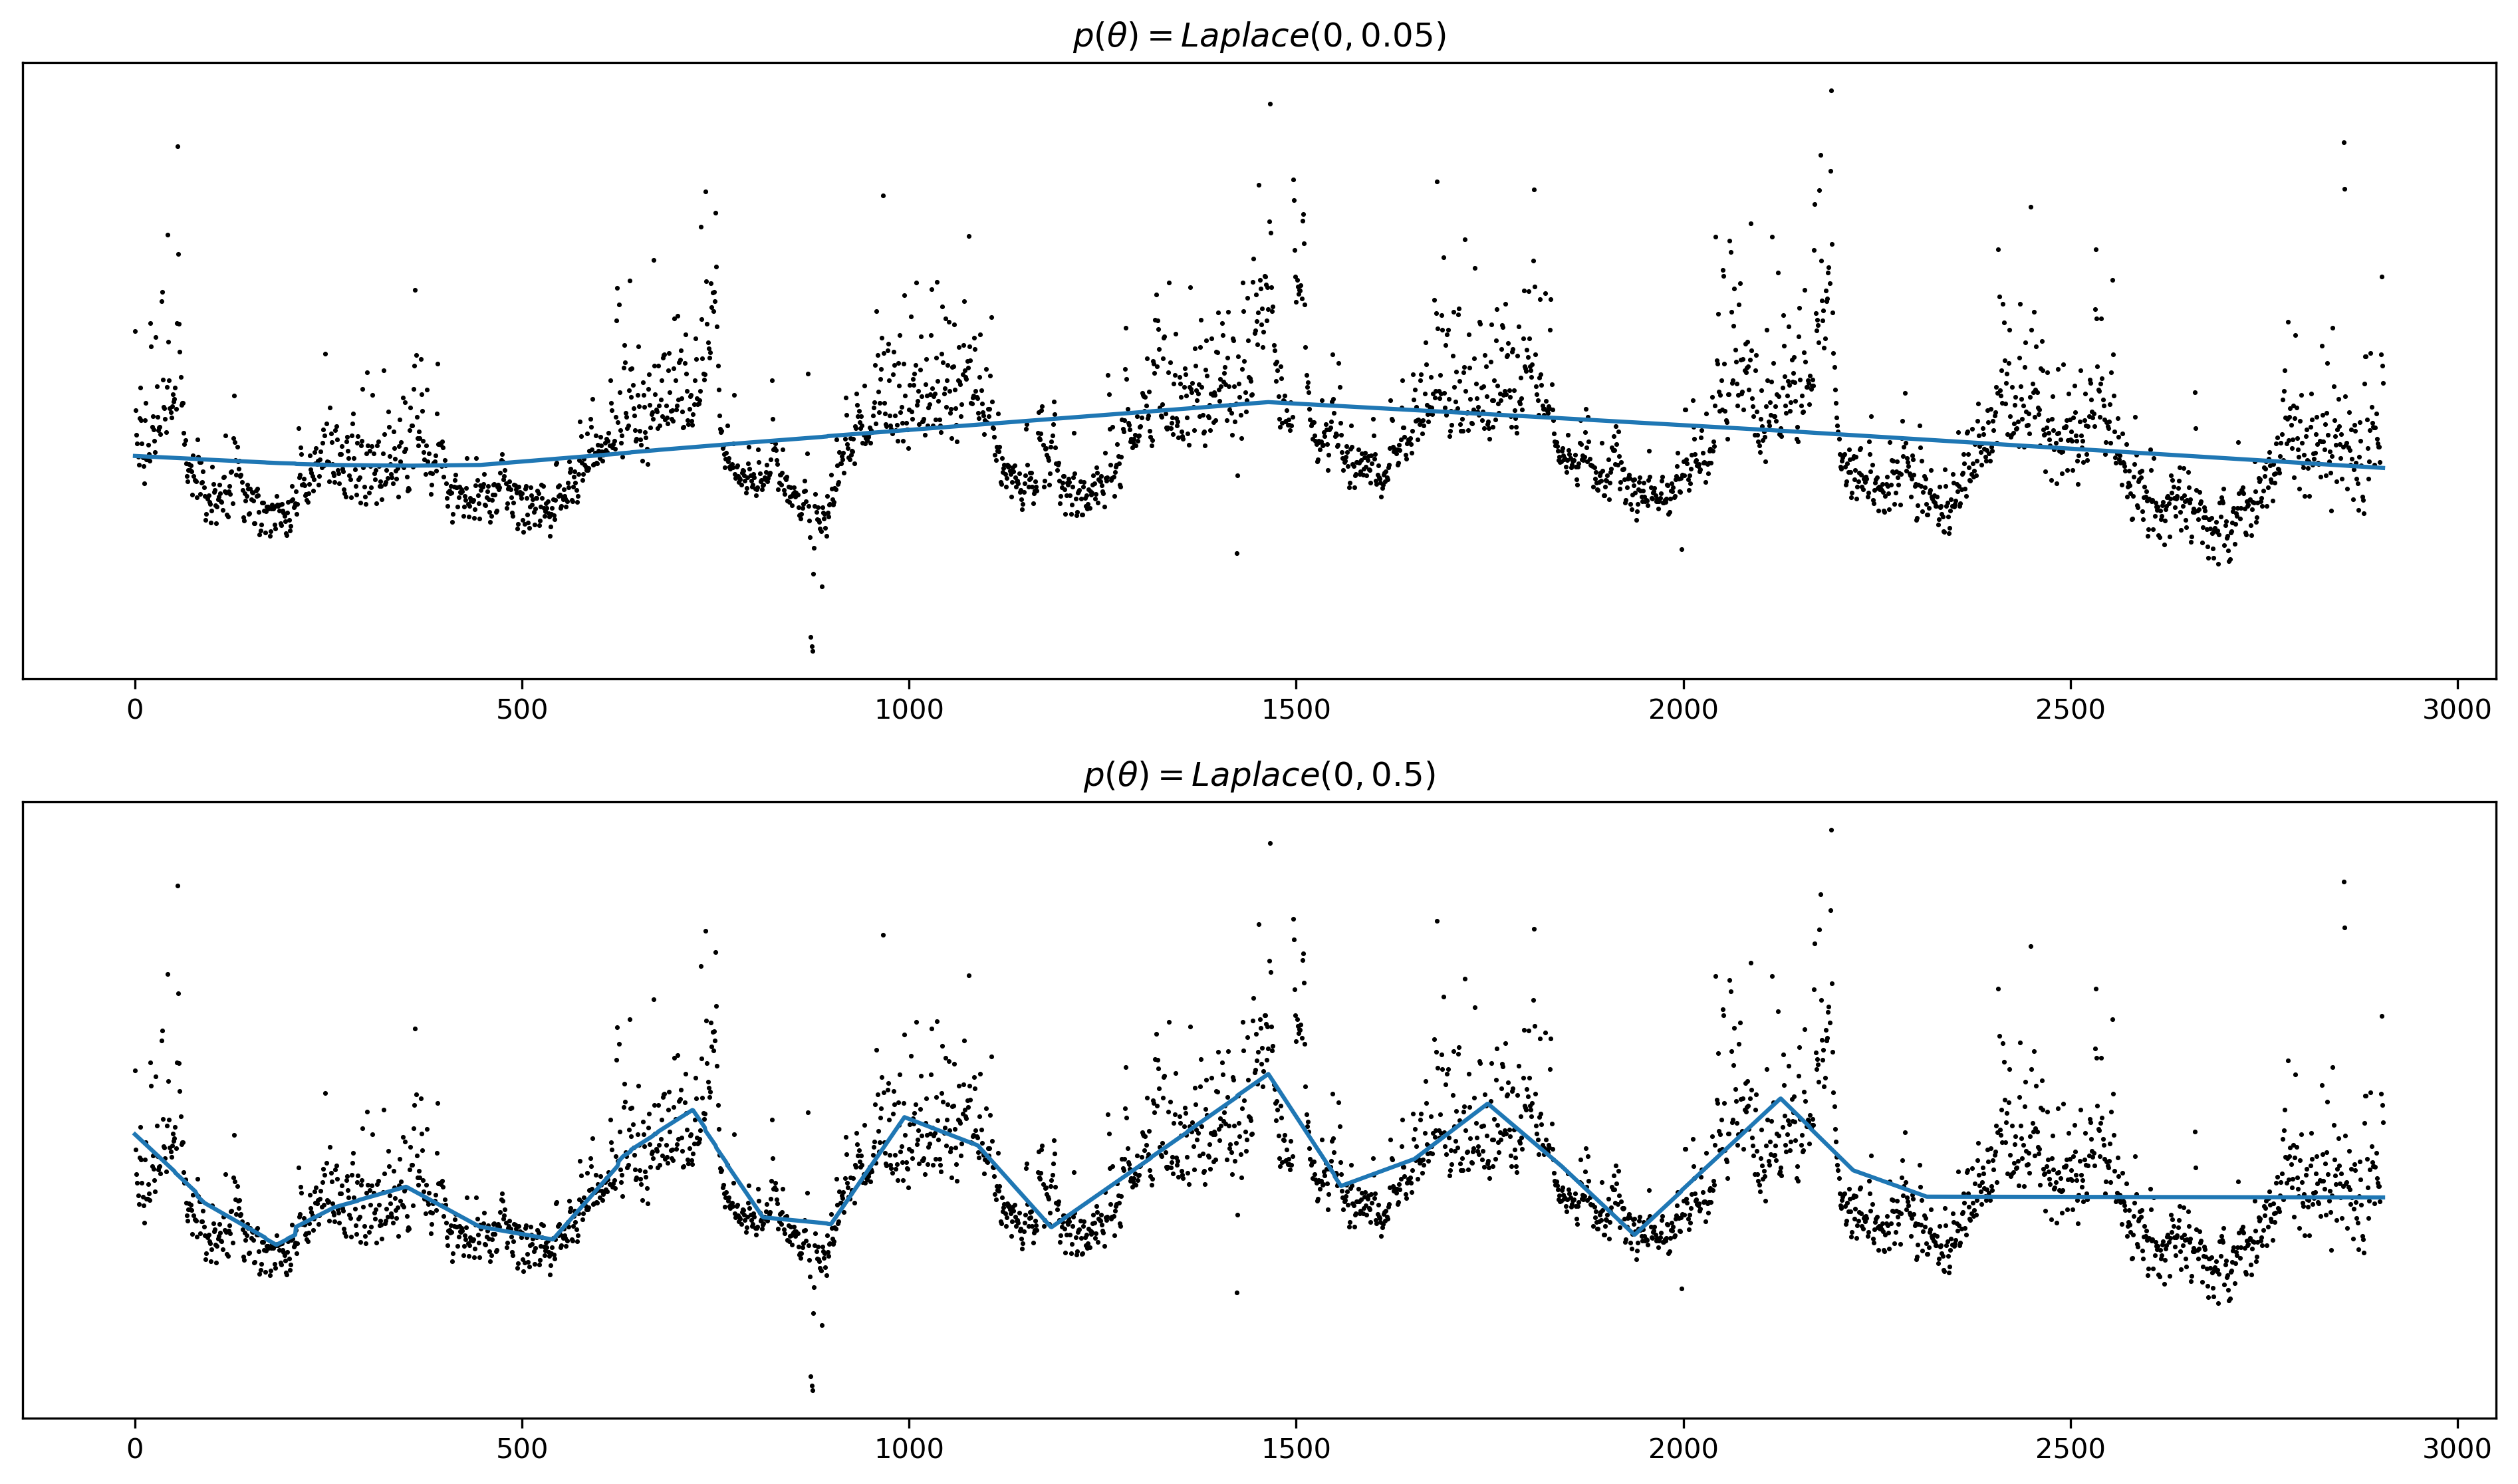

In [14]:
# Determine g, based on the parameters
def det_trend(k, m, delta, t, s, A):
    return (k + np.dot(A, delta)) * t + (m + np.dot(A, (-s * delta)))

# run function and rescale to original scale
g_1 = det_trend(aprox_1['k'], aprox_1['m'], aprox_1['delta'], df['t'], s, A) * (df['y'].max() - df['y'].min()) + df['y'].min()
g_2 = det_trend(aprox_2['k'], aprox_2['m'], aprox_2['delta'], df['t'], s, A) * (df['y'].max() - df['y'].min()) + df['y'].min()

plt.figure(figsize=(16, 9), dpi=300)

plt.subplot(211)
plt.title('$p(\\theta) = Laplace(0, 0.05)$')
plt.plot(g_1)
plt.scatter(np.arange(df.shape[0]), df.y, s=0.5, color='black')
plt.yticks([])


plt.subplot(212)
plt.title('$p(\\theta) = Laplace(0, 0.5)$')
plt.plot(g_2)
plt.scatter(np.arange(df.shape[0]), df.y, s=0.5, color='black')
plt.yticks([])


Text(0.5, 1.0, 'Fourier series')

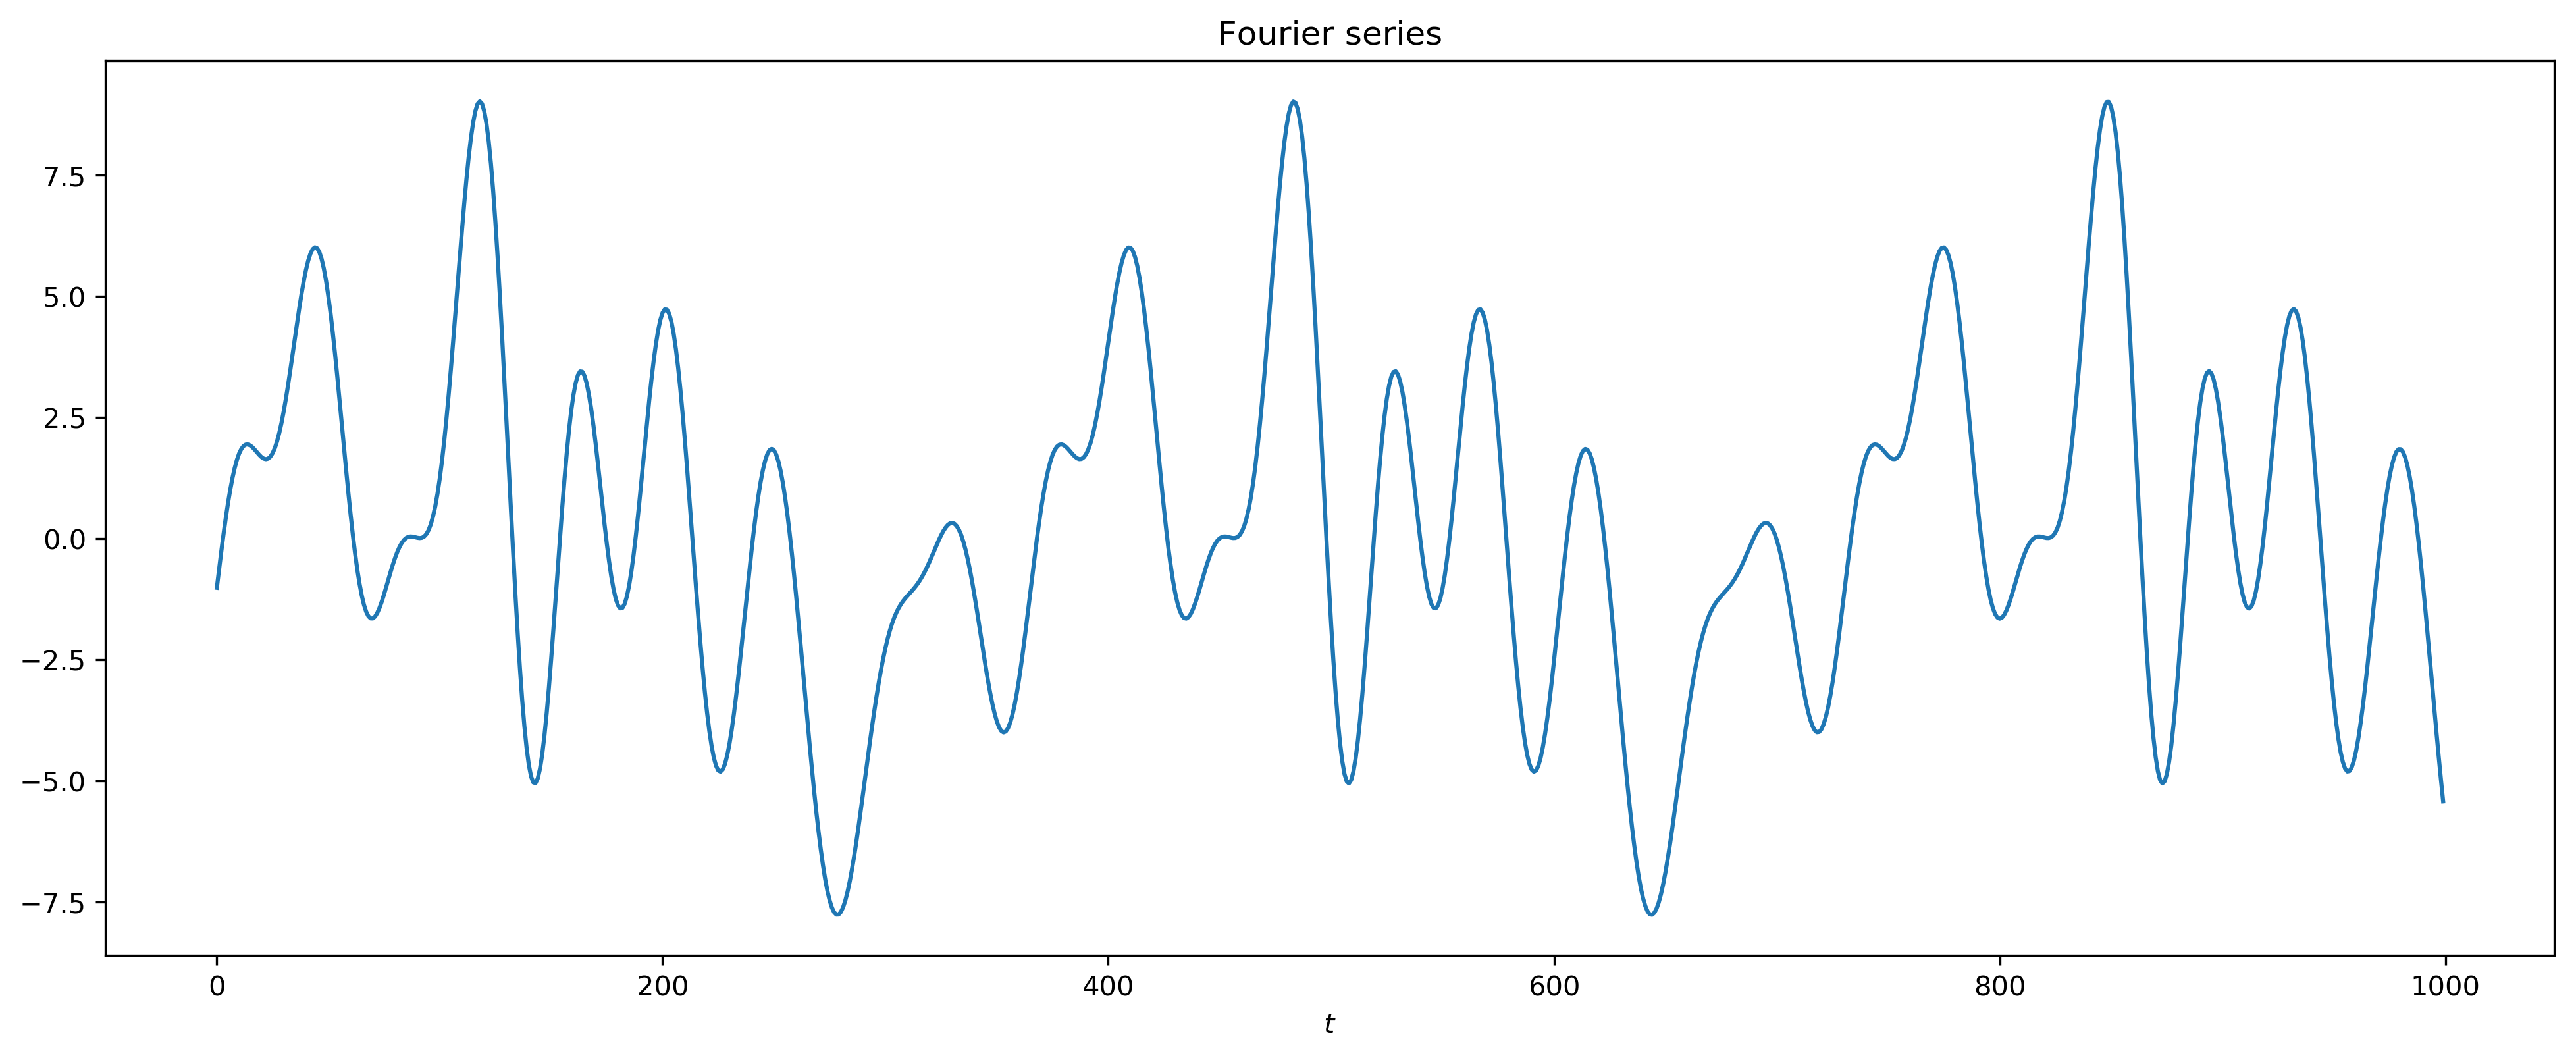

In [16]:
np.random.seed(6)
def fourier_series(t, p, n):
    # 2 pi n / p
    x = 2 * np.pi * np.arange(1, n + 1) / p
    # 2 pi n / p * t
    x = x * t[:, None]
    x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
    return x

n = 10
t = np.arange(1000)
beta = np.random.normal(size=2 * n)
np.dot(fourier_series(t, 365.25, n), beta)

plt.figure(figsize=(16, 6), dpi=300)
plt.plot(np.dot(fourier_series(t, 365.25, n), beta))
plt.xlabel('$t$')
plt.title('Fourier series')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_weekly, beta_yearly, m, delta, tau, k]
Sampling 4 chains: 100%|██████████| 4000/4000 [15:36<00:00,  1.47draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/opt/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`',

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf231a7d68>,
      dtype=object)

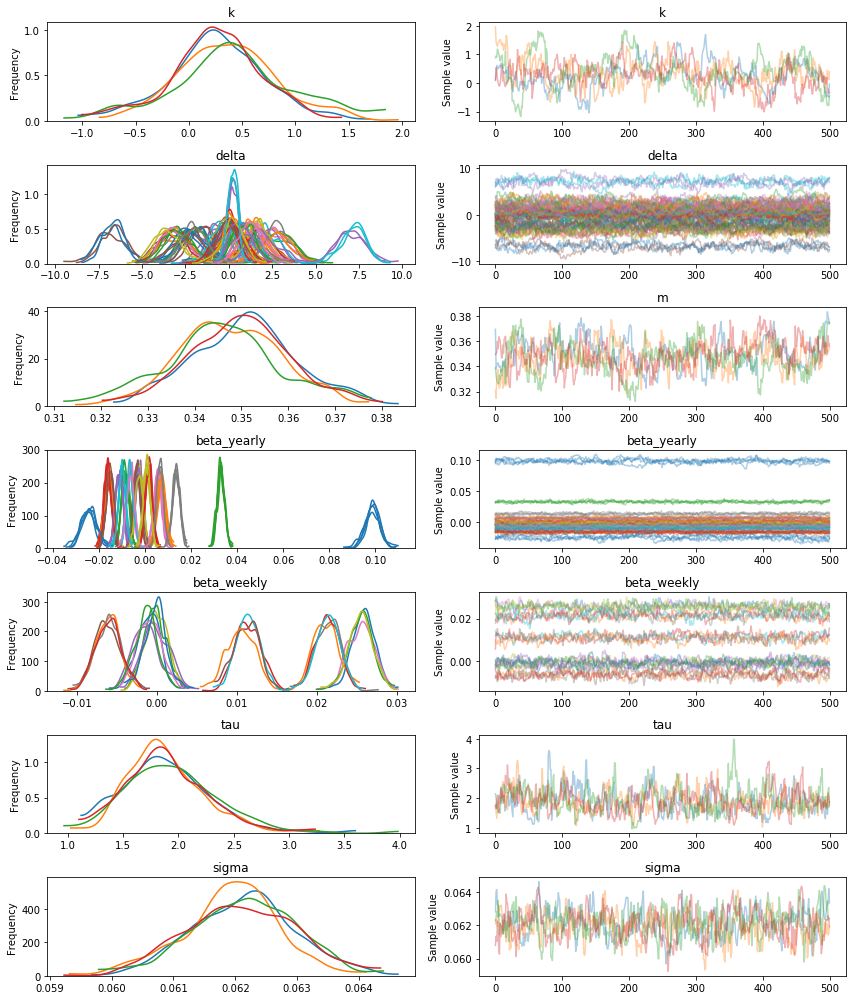

In [17]:
def seasonality_model(m, df, period='yearly', seasonality_prior_scale=10):
    
    if period == 'yearly':
        n = 10
        # rescale the period, as t is also scaled
        p = 365.25 / (df['ds'].max() - df['ds'].min()).days
    else:  # weekly
        n = 3
        # rescale the period, as t is also scaled
        p = 7 / (df['ds'].max() - df['ds'].min()).days
    x = fourier_series(df['t'], p, n)
    with m:
        beta = pm.Normal(f'beta_{period}', mu=0, sd=seasonality_prior_scale, shape=2 * n)
    return x, beta

m = pm.Model()

with m:
    # changepoints_prior_scale is None, so the exponential distribution
    # will be used as prior on \tau.
    y, A, s = trend_model(m, df['t'], changepoints_prior_scale=None)
    x_yearly, beta_yearly = seasonality_model(m, df, 'yearly')
    x_weekly, beta_weekly = seasonality_model(m, df, 'weekly')
    
    y += det_dot(x_yearly, beta_yearly) + det_dot(x_weekly, beta_weekly)
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    obs = pm.Normal('obs', 
                 mu=y, 
                 sd=sigma,
                 observed=df['y_scaled'])
with m:
    trace = pm.sample(500)
pm.traceplot(trace)

/opt/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf22da19b0>,
      dtype=object)

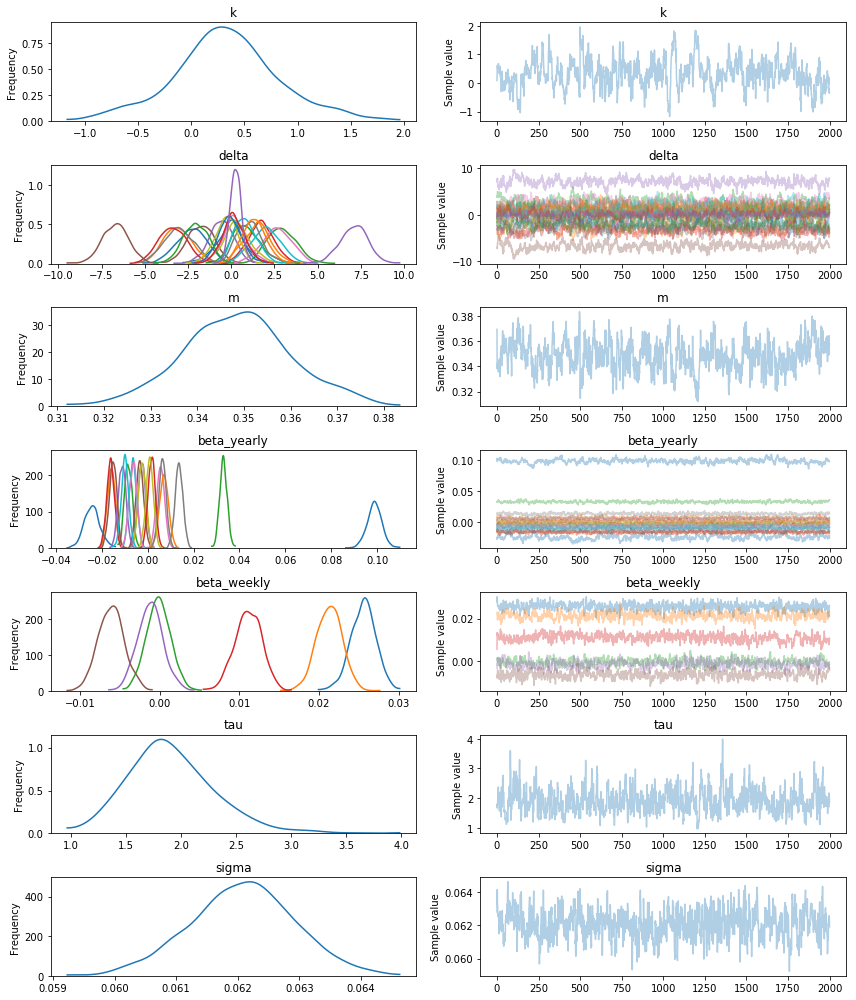

In [19]:
pm.traceplot(trace, combined=True)

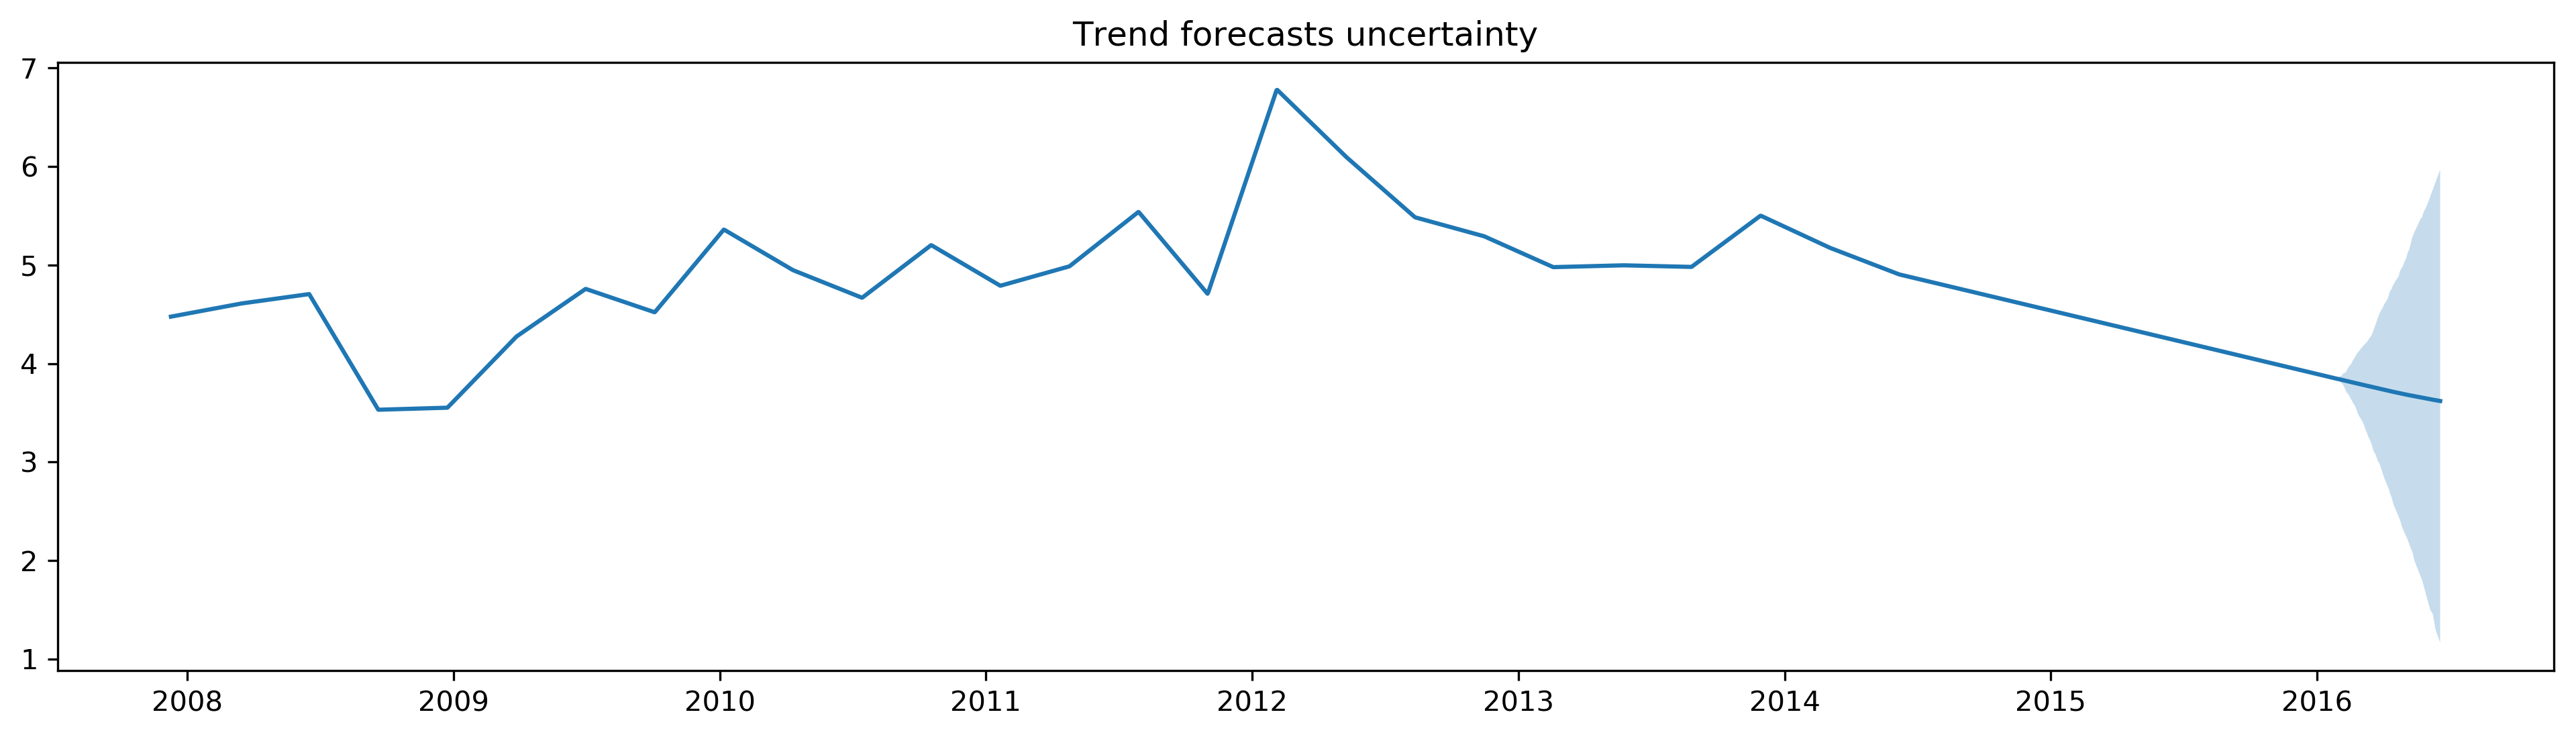

In [20]:
n_samples = 1000
days = 150
history_points = df.shape[0]
probability_changepoint = n_changepoints / history_points

future = pd.DataFrame({'ds': pd.date_range(df['ds'].min(), 
                                           df['ds'].max() + pd.Timedelta(days, 'D'), 
                        df.shape[0] + days)})
future['t'] = (future['ds'] - df['ds'].min()) / (df['ds'].max() - df['ds'].min())

# vector distributions
beta_yearly = trace['beta_yearly'].mean(0)
beta_weekly = trace['beta_weekly'].mean(0)
delta = trace['delta'].mean(0)

# scalar distributions
k = trace['k'].mean()
m = trace['m'].mean()

trend_forecast = []
lambda_ = trace['tau'].mean()

for n in range(n_samples):
    new_changepoints = future['t'][future['t'] > 1].values
    sample = np.random.random(new_changepoints.shape)
    new_changepoints = new_changepoints[sample <= probability_changepoint]
    new_delta = np.r_[delta, 
                      stats.laplace(0, lambda_).rvs(new_changepoints.shape[0])]
    new_s = np.r_[s, new_changepoints]
    new_A = (future['t'][:, None] > new_s) * 1

    trend_forecast.append(((k + np.dot(new_A, new_delta)) * future['t']  + (m + np.dot(new_A, (-new_s * new_delta)))) * df['y'].max())
    
trend_forecast = np.array(trend_forecast)

date = future['ds'].dt.to_pydatetime()
plt.figure(figsize=(16, 4), dpi=300)
plt.title('Trend forecasts uncertainty')
plt.plot(date, trend_forecast.mean(0))
quant = np.quantile(trend_forecast, [0.025, 0.975], axis=0)
plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25)


In [23]:
np.array([stats.norm(h_i, 5).pdf([200, 190]) for h_i in h]).prod(1)


array([1.55500793e-38, 1.20261543e-36, 8.24949390e-35, 5.01919659e-33,
       2.70861622e-31, 1.29648385e-29, 5.50418620e-28, 2.07264770e-26,
       6.92252017e-25, 2.05073403e-23, 5.38841224e-22, 1.25579473e-20,
       2.59586958e-19, 4.75941362e-18, 7.73981173e-17, 1.11638428e-15,
       1.42824725e-14, 1.62068811e-13, 1.63117991e-12, 1.45616521e-11,
       1.15299071e-10, 8.09743236e-10, 5.04400164e-09, 2.78682358e-08,
       1.36568363e-07, 5.93604380e-07, 2.28849759e-06, 7.82546562e-06,
       2.37342922e-05, 6.38482136e-05, 1.52344782e-04, 3.22413178e-04,
       6.05207573e-04, 1.00763279e-03, 1.48801255e-03, 1.94902436e-03,
       2.26430178e-03, 2.33323088e-03, 2.13249239e-03, 1.72871593e-03,
       1.24298574e-03, 7.92711257e-04, 4.48404821e-04, 2.24973771e-04,
       1.00115166e-04, 3.95161133e-05, 1.38342284e-05, 4.29577996e-06,
       1.18313821e-06, 2.89024930e-07])

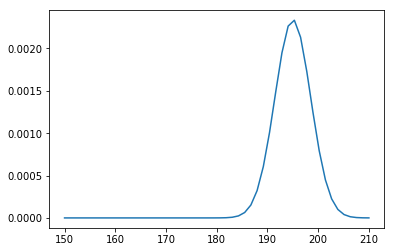

In [24]:
plt.plot(h, np.array([stats.norm(h_i, 5).pdf([200, 190]) for h_i in h]).prod(1))

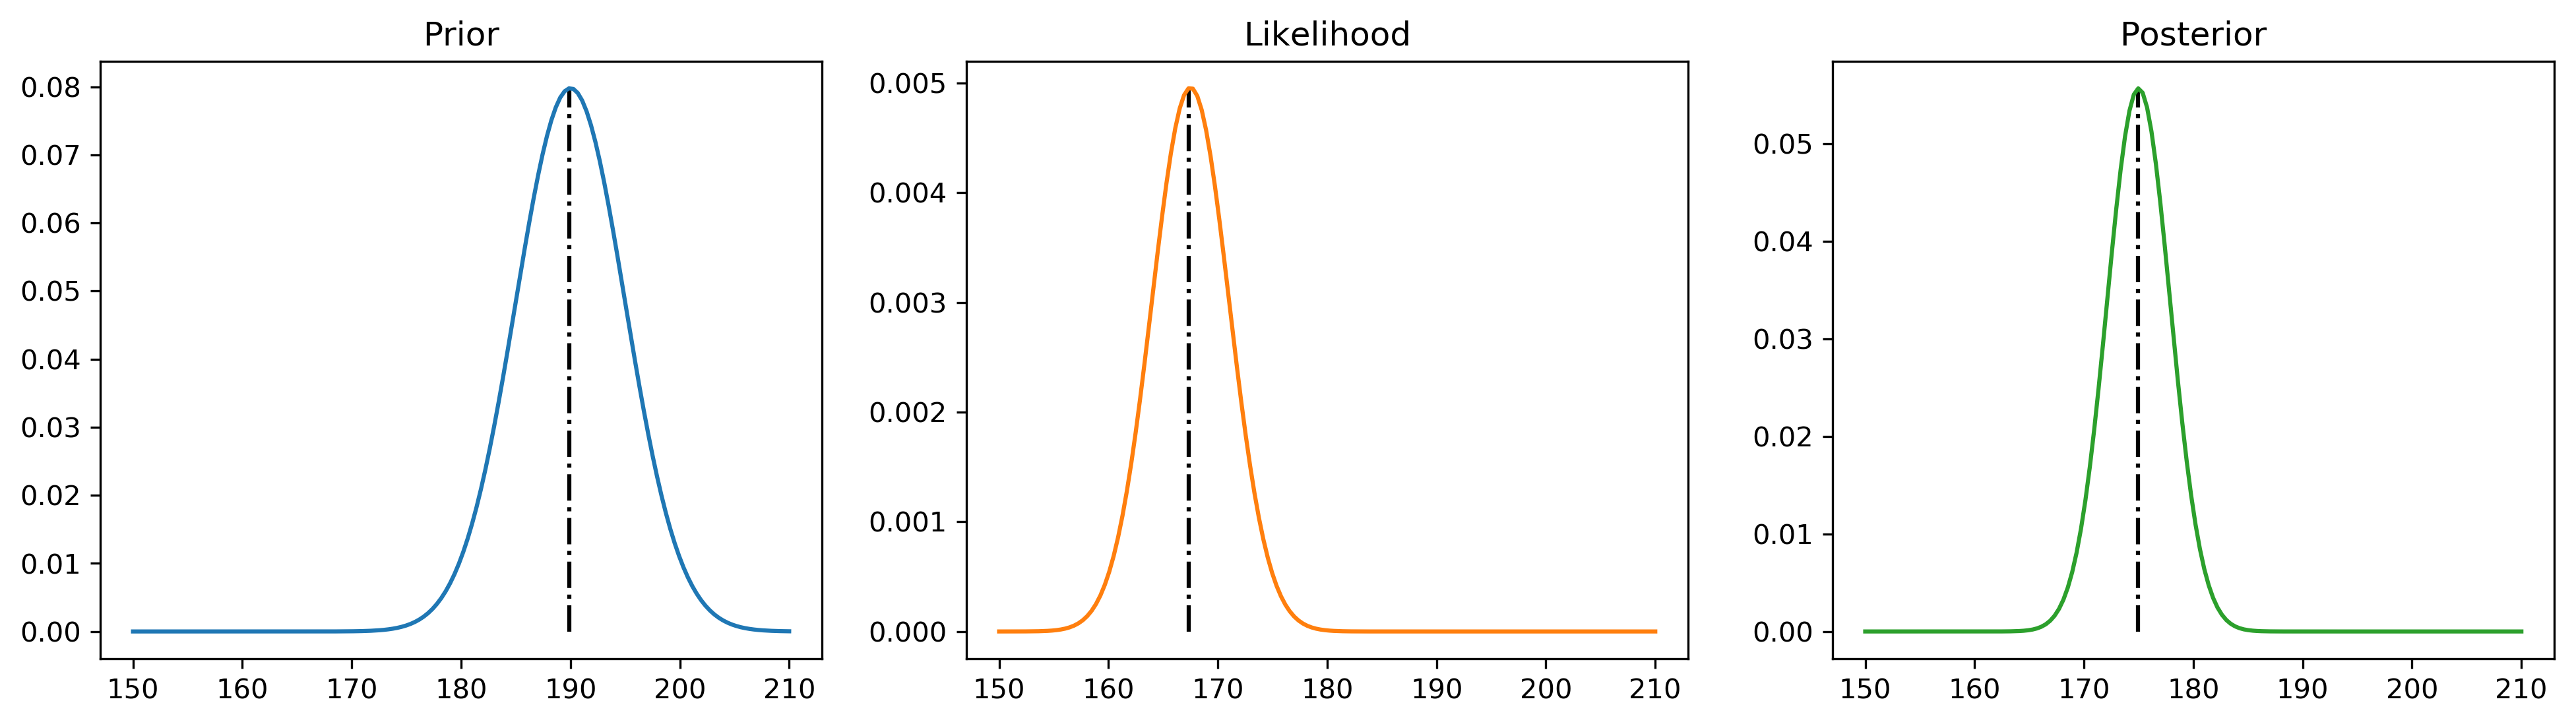

In [58]:
m = stats.norm(190, 5)
h = np.linspace(150, 210, num=150)

prior = m.pdf(h)
likelihood = np.array([stats.norm(h_i, 5).pdf([165, 170]) for h_i in h]).prod(1)
unnormalized_posterior = prior * likelihood
posterior = unnormalized_posterior / unnormalized_posterior.sum()

plt.figure(figsize=(16, 4), dpi=300)
plt.subplot(131)
plt.title('Prior')
plt.plot(h, prior)
plt.vlines(h[prior.argmax()], 0, prior.max(), linestyles='-.')
plt.subplot(132)
plt.title('Likelihood')
plt.plot(h, likelihood, color='C1')
plt.vlines(h[likelihood.argmax()], 0, likelihood.max(), linestyles='-.')
plt.subplot(133)
plt.title('Posterior')
plt.plot(h, posterior, color='C2')
plt.vlines(h[posterior.argmax()], 0, posterior.max(), linestyles='-.')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6103.19draws/s]


(150, 210)

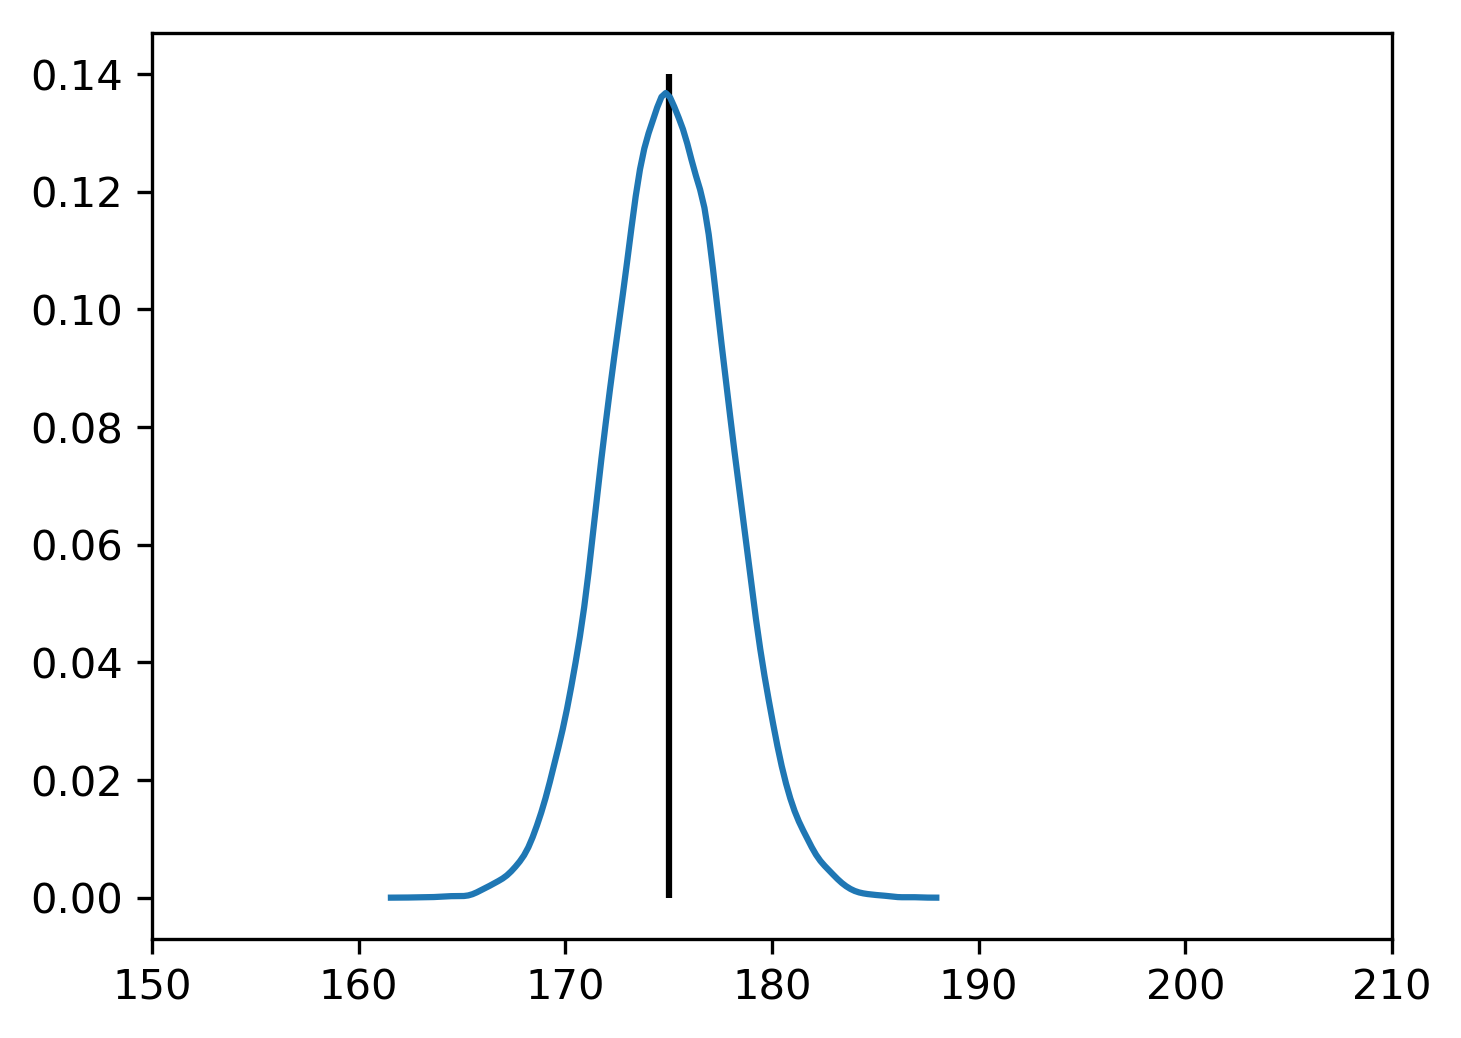

In [42]:
with pm.Model() as m:
    mu = pm.Normal('mu', 190, 5)
    pm.Normal('likelihood', mu, 5, observed=[165, 170])
    trace = pm.sample(10000)


(150, 210)

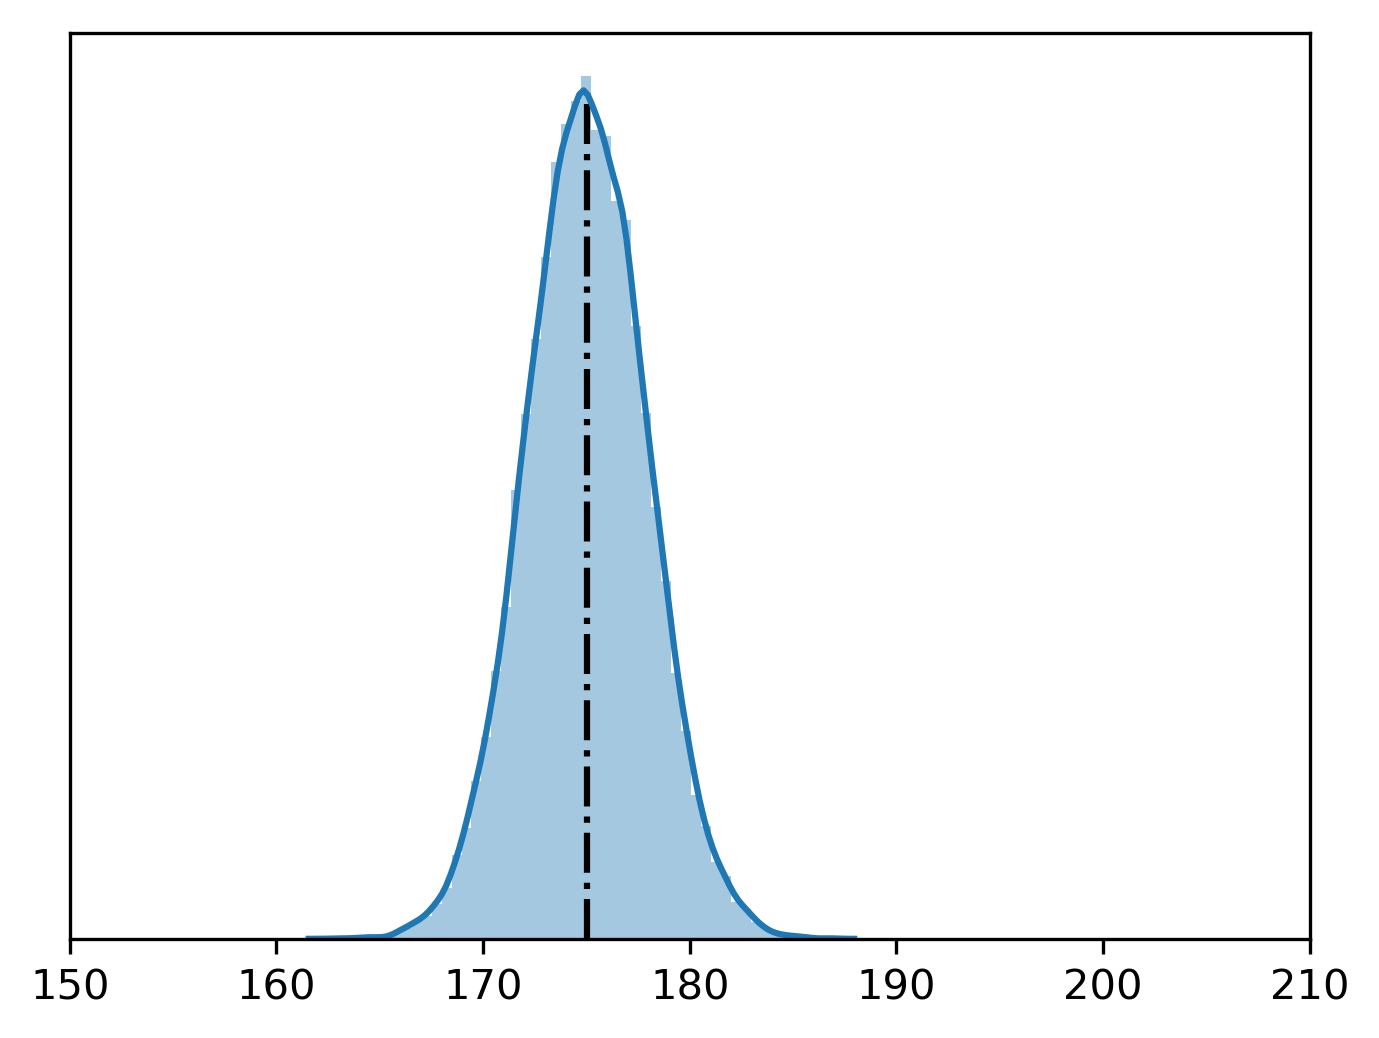

In [48]:
plt.figure(figsize=(16 / 3, 4), dpi=300)
sns.distplot(trace['mu'], hist=True)
plt.yticks([])
plt.vlines(trace['mu'].mean(), 0, 0.135, linestyle='-.')
plt.xlim(150, 210)